# HDF-N master catalogue
## Preparation of CANDELS-GOODS-N data

CANDELS-GOODS-N catalogue: the catalogue comes from `dmu0_CANDELS-GOODS-N`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The total magnitude.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "candels-gn_ra"
DEC_COL = "candels-gn_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'ID': "candels-gn_id",
        'RA': "candels-gn_ra",
        'DEC': "candels-gn_dec",
        'CLASS_STAR':  "candels-gn_stellarity",
    #HST data
        'ACS_F435W_FLUX': "f_acs_f435w", 
        'ACS_F435W_FLUXERR': "ferr_acs_f435w", 
        'ACS_F606W_FLUX': "f_acs_f606w", 
        'ACS_F606W_FLUXERR': "ferr_acs_f606w", 
        'ACS_F775W_FLUX': "f_acs_f775w", 
        'ACS_F775W_FLUXERR': "ferr_acs_f775w", 
        'ACS_F814W_FLUX': "f_acs_f814w", 
        'ACS_F814W_FLUXERR': "ferr_acs_f814w", 
        'ACS_F850LP_FLUX': "f_acs_f850lp", 
        'ACS_F850LP_FLUXERR': "ferr_acs_f850lp", 
    
        'WFC3_F105W_FLUX': "f_acs_f105w", 
        'WFC3_F105W_FLUXERR': "ferr_acs_f105w", 
        'WFC3_F125W_FLUX': "f_acs_f125w", 
        'WFC3_F125W_FLUXERR': "ferr_acs_f125w", 
        'WFC3_F140W_FLUX': "f_acs_f140w", 
        'WFC3_F140W_FLUXERR': "ferr_acs_f140w", 
        'WFC3_F160W_FLUX': "f_acs_f160w", 
        'WFC3_F160W_FLUXERR': "ferr_acs_f160w", 
    #MOIRCS?
        'MOIRCS_K_FLUX':"f_moircs_k",
        'MOIRCS_K_FLUXERR':"ferr_moircs_k",
    #CFHT WIRCAM
        'CFHT_Ks_FLUX': "f_candels-wircam_k",# 33 WIRCAM_K_FLUX Flux density (in μJy) in the Ks-band (CFHT/WIRCam) (3)
        'CFHT_Ks_FLUXERR': "ferr_candels-wircam_k",# 34 WIRCAM_K_FLUXERR 
    #Spitzer/IRAC
        'IRAC_CH1_SCANDELS_FLUX': "f_candels-irac_i1",# 47 IRAC_CH1_FLUX Flux density (in μJy) in the 3.6μm-band (Spitzer/IRAC) (3)
        'IRAC_CH1_SCANDELS_FLUXERR': "ferr_candels-irac_i1",# 48 IRAC_CH1_FLUXERR Flux uncertainty (in μJy) in the 3.6μm-band (Spitzer/IRAC) (3)
        'IRAC_CH2_SCANDELS_FLUX': "f_candels-irac_i2",# 49 IRAC_CH2_FLUX Flux density (in μJy) in the 4.5μm-band (Spitzer/IRAC) (3)
        'IRAC_CH2_SCANDELS_FLUXERR': "ferr_candels-irac_i2",# 50 IRAC_CH2_FLUXERR Flux uncertainty (in μJy) in the 4.5μm-band (Spitzer/IRAC) (3)
        'IRAC_CH3_FLUX': "f_candels-irac_i3",# 51 IRAC_CH3_FLUX Flux density (in μJy) in the 5.8μm-band (Spitzer/IRAC) (3)
        'IRAC_CH3_FLUXERR': "ferr_candels-irac_i3",# 52 IRAC_CH3_FLUXERR Flux uncertainty (in μJy) in the 5.8μm-band (Spitzer/IRAC) (3)
        'IRAC_CH4_FLUX': "f_candels-irac_i4",# 53 IRAC_CH4_FLUX Flux density (in μJy) in the 8.0μm-band (Spitzer/IRAC) (3)
        'IRAC_CH4_FLUXERR': "ferr_candels-irac_i4"# 54 IRAC_CH4_FLUXERR
    
    
    })


catalogue = Table.read("../../dmu0/dmu0_CANDELS-GOODS-N/data/CANDELS.GOODSN.F160W.v1_1.photom.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        #catalogue[col][catalogue[col] <= 0] = np.nan
        #catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        mag, error = flux_to_mag(np.array(catalogue[col])*1.e-6, np.array(catalogue[errcol])*1.e-6)
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        

        catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="m_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="merr_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="f_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="ferr_ap{}".format(col[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: divide by zero encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


In [6]:
catalogue[:10].show_in_notebook()

idx,candels-gn_id,candels-gn_ra,candels-gn_dec,candels-gn_stellarity,f_acs_f435w,ferr_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_acs_f105w,ferr_acs_f105w,f_acs_f125w,ferr_acs_f125w,f_acs_f140w,ferr_acs_f140w,f_acs_f160w,ferr_acs_f160w,f_moircs_k,ferr_moircs_k,f_candels-wircam_k,ferr_candels-wircam_k,f_candels-irac_i1,ferr_candels-irac_i1,f_candels-irac_i2,ferr_candels-irac_i2,f_candels-irac_i3,ferr_candels-irac_i3,f_candels-irac_i4,ferr_candels-irac_i4,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,flag_acs_f435w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,flag_acs_f606w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,flag_acs_f775w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,flag_acs_f814w,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,flag_acs_f850lp,m_acs_f105w,merr_acs_f105w,m_ap_acs_f105w,merr_ap_acs_f105w,f_ap_acs_f105w,ferr_ap_acs_f105w,flag_acs_f105w,m_acs_f125w,merr_acs_f125w,m_ap_acs_f125w,merr_ap_acs_f125w,f_ap_acs_f125w,ferr_ap_acs_f125w,flag_acs_f125w,m_acs_f140w,merr_acs_f140w,m_ap_acs_f140w,merr_ap_acs_f140w,f_ap_acs_f140w,ferr_ap_acs_f140w,flag_acs_f140w,m_acs_f160w,merr_acs_f160w,m_ap_acs_f160w,merr_ap_acs_f160w,f_ap_acs_f160w,ferr_ap_acs_f160w,flag_acs_f160w,m_moircs_k,merr_moircs_k,m_ap_moircs_k,merr_ap_moircs_k,f_ap_moircs_k,ferr_ap_moircs_k,flag_moircs_k,m_candels-wircam_k,merr_candels-wircam_k,m_ap_candels-wircam_k,merr_ap_candels-wircam_k,f_ap_candels-wircam_k,ferr_ap_candels-wircam_k,flag_candels-wircam_k,m_candels-irac_i1,merr_candels-irac_i1,m_ap_candels-irac_i1,merr_ap_candels-irac_i1,f_ap_candels-irac_i1,ferr_ap_candels-irac_i1,flag_candels-irac_i1,m_candels-irac_i2,merr_candels-irac_i2,m_ap_candels-irac_i2,merr_ap_candels-irac_i2,f_ap_candels-irac_i2,ferr_ap_candels-irac_i2,flag_candels-irac_i2,m_candels-irac_i3,merr_candels-irac_i3,m_ap_candels-irac_i3,merr_ap_candels-irac_i3,f_ap_candels-irac_i3,ferr_ap_candels-irac_i3,flag_candels-irac_i3,m_candels-irac_i4,merr_candels-irac_i4,m_ap_candels-irac_i4,merr_ap_candels-irac_i4,f_ap_candels-irac_i4,ferr_ap_candels-irac_i4,flag_candels-irac_i4
,,,,"0 galaxy, 1 star",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,189.15216178,62.09177764,0,-0.03041,0.03046,-0.01637,0.03921,0.036,0.0591,-0.00105,64894254393.4,-0.07984,0.07474,-0.07928,0.05425,0.00583,0.03354,-2e-05,40607499435.5,0.73155,0.37962,0.01084,1444.70263,-0.20261,0.09029,-0.08455,0.13695,-0.18952,0.13653,-0.37712,1.00009,-0.35061,1.52074,nan,-1.08752136787,nan,nan,nan,nan,False,nan,-2.60059356069,nan,nan,nan,nan,False,27.5092437481,1.78241693614,nan,nan,nan,nan,False,nan,-6.71028966435e+13,nan,nan,nan,nan,False,nan,-1.01638181292,nan,nan,nan,nan,False,nan,-0.742951426692,nan,nan,nan,nan,False,29.4858286131,6.2462422483,nan,nan,nan,nan,False,nan,-2.20445161609e+15,nan,nan,nan,nan,False,24.2393899634,0.563416277835,nan,nan,nan,nan,False,28.8124267945,144701.65595,nan,nan,nan,nan,False,nan,-0.483841478346,nan,nan,nan,nan,False,nan,-1.75862298334,nan,nan,nan,nan,False,nan,-0.782163170302,nan,nan,nan,nan,False,nan,-2.8792795954,nan,nan,nan,nan,False,nan,-4.70928517733,nan,nan,nan,nan,False
1,2,189.14883356,62.09202743,0,-0.04039,0.12865,0.02556,0.15445,0.05139,0.23871,-0.00188,264842218594.0,-0.18039,0.3039,-0.0424,0.25053,0.23843,0.15215,-0.00038,165724690769.0,1.09767,0.38818,0.00992,1395.40524,0.00836,0.08557,0.05314,0.13861,0.62588,0.13547,-0.54797,0.99801,-1.1307,1.33768,nan,-3.45828083046,nan,nan,nan,nan,False,27.8810978763,6.56071818564,nan,nan,nan,nan,False,27.1228034558,5.04331756057,nan,nan,nan,nan,False,nan,-1.5295148153e+14,nan,nan,nan,nan,False,nan,-1.82912152905,nan,nan,nan,nan,False

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ["merr_acs_f435w","ferr_acs_f606w",
             "ferr_acs_f775w","ferr_acs_f814w",
             "ferr_acs_f850lp", "ferr_acs_f105w",
             "ferr_acs_f125w","ferr_acs_f140w","ferr_acs_f160w"]
FLAG_NAME = 'candels-gn_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 35445 sources.
The cleaned catalogue has 35423 sources (22 removed).
The cleaned catalogue has 21 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_HDF-N.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

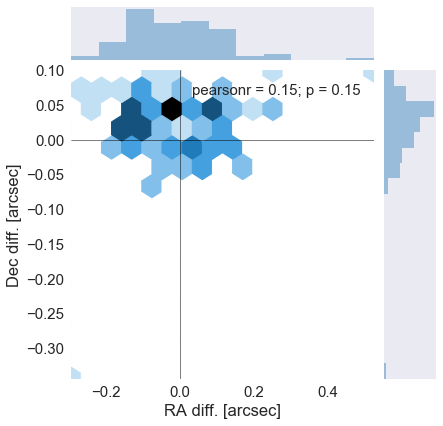

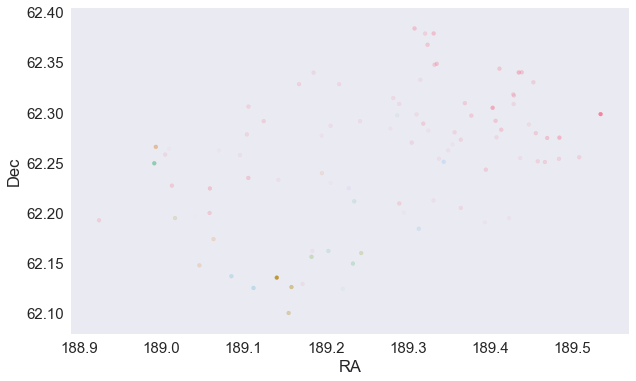

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.02082349079728374 arcsec
Dec correction: -0.02865639995377478 arcsec


In [11]:
catalogue[RA_COL].unit = u.deg
catalogue[DEC_COL].unit = u.deg
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

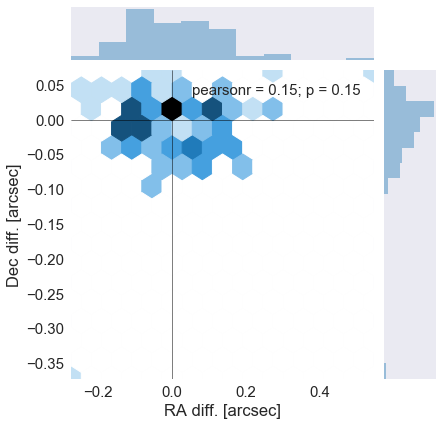

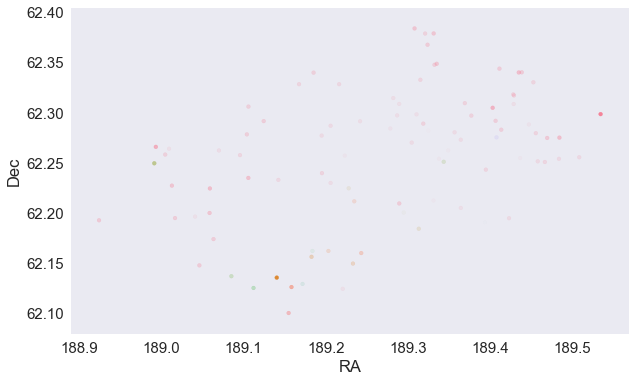

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "candels-gn_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

102 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/CANDELS-GOODS-N.fits".format(OUT_DIR), overwrite=True)